# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=222f53c379221e38a0b9c447a0ab7d4e531988560d3aba4dba25e76f1a1493e8
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 11.93s ==============================


## Finding Optimum lr and dropout rate

In [4]:
import torch
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import torch.optim as optim
import copy


def lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders):
    
    if torch.cuda.is_available():
        model.cuda()
    
    # Save initial weights so we can restore them at the end
    torch.save(model.state_dict(), "__weights_backup")
    
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=min_lr)

    # We create a learning rate scheduler that increases the learning
    # rate at every batch.
    # Find the factor where min_lr r**(n_steps-1) = max_lr
    r = np.power(max_lr / min_lr, 1 / (n_steps - 1))

    def new_lr(epoch):
        """
        This should return the *factor* by which the initial learning
        rate must be multipled for to get the desired learning rate
        """
        return r ** epoch

    # This scheduler increases the learning rate by a constanct factor (r)
    # at every iteration
    lr_scheduler = LambdaLR(optimizer, new_lr)

    # Set the model in training mode
    # (so all layers that behave differently between training and evaluation,
    # like batchnorm and dropout, will select their training behavior)
    model.train()

    # Loop over the training data
    losses = {}
    train_loss = 0.0
    
    keep_going = True
    n = 0
    
    while keep_going:
        for batch_idx, (data, target) in tqdm(
            enumerate(data_loaders["train"]),
            desc="Learning rate finder",
            total=len(data_loaders["train"]),
            leave=True,
            ncols=80,
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. clear the gradients of all optimized variables
            optimizer.zero_grad()  # -
            # 2. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 3. calculate the loss
            loss_value = loss(output, target)  # =
            # 4. backward pass: compute gradient of the loss with respect to model parameters
            loss_value.backward()  # -
            # 5. perform a single optimization step (parameter update)
            optimizer.step()  # -

            train_loss = train_loss + (
                (1 / (n + 1)) * (loss_value.data.item() - train_loss)
            )

            losses[lr_scheduler.get_last_lr()[0]] = train_loss

            # Stop if the loss gets too big
            if train_loss / min(losses.values()) > 10:
                break

            if n == n_steps - 1:
                keep_going = False
                break
            else:
                # Increase the learning rate for the next iteration
                lr_scheduler.step()
            
            n += 1
    
    # Restore model to its initial state
    model.load_state_dict(torch.load('__weights_backup'))
    
    return losses

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


Learning rate finder:  95%|██████████████████ | 119/125 [03:56<00:11,  1.99s/it]


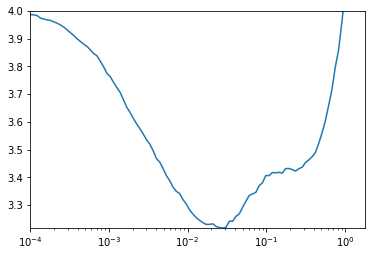

In [5]:
import torch.nn as nn
from src.data import get_data_loaders
from src.transfer import get_model_transfer_learning
import matplotlib.pyplot as plt
import multiprocessing

batch_size = 32
valid_size = 0.2
num_workers = multiprocessing.cpu_count()
lr_model_transfer = get_model_transfer_learning("resnet18", n_classes=50)
lr_dataloaders = get_data_loaders(batch_size, valid_size, num_workers=num_workers)
lr_loss = nn.CrossEntropyLoss()
losses = lr_finder(1e-5, 1, 120, lr_loss, lr_model_transfer, lr_dataloaders)
_ = plt.plot(losses.keys(), losses.values())
_ = plt.xscale("log")

_ = plt.xlim([1e-4, None])
_ = plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

I varied the optimer between SGD and Adam and got a better result with Adam. So we will be using Adam optimer for computing loss. Looking at the grapgh above, it is clear the optimum learning rate is between 0.001 and 0.01. So i will experiment between using 0.006 and 0.01

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [2]:
batch_size = 32  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

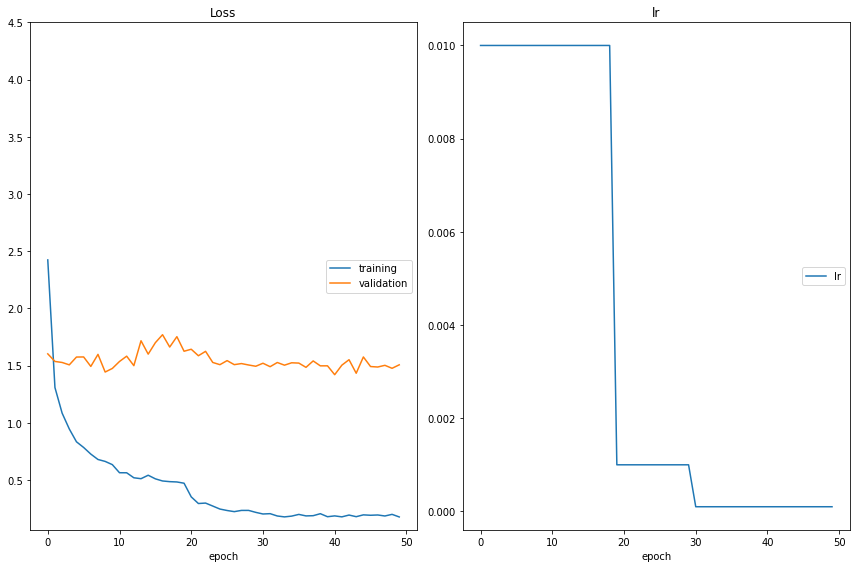

In [3]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes) # YOUR CODE HERE

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ 

## Steps to Final CNN Architecture

1. **Choice of Pretrained Model:**
    - **Step:** Selected a pretrained model, ResNet-18.
    - **Reasoning:** This Pretrained models have already been trained on large datasets like ImageNet and have learned rich feature representations. Using it allows me to leverage these pre-learned features for the specific task, which can lead to faster convergence and better performance, especially the dataset is not very large.

2. **Freezing Parameters:**
    - **Step:** Froze all layers of the pretrained model.
    - **Reasoning:** Freezing the parameters prevents the weights of the pretrained layers from being updated during training, which helps retain the useful features learned during pretraining. This is particularly useful for our dataset is somewhat not large enough to train a deep network from scratch.

3. **Custom Classification Head:**
    - **Step:** Replaced the final fully connected layer with a custom classifier suitable for the specific problem.
    - **Reasoning:** The original final layer of the pretrained model is typically designed for the number of classes in the ImageNet dataset (e.g., 1000 classes). This problem has a different number of classes, 50, so we need to replace this layer to output the correct number of classes.

4. **Design of Custom Classifier:**
    - **Step:** Added a new classification head with the following structure:
        ```python
        nn.Sequential(
            nn.BatchNorm1d(num_ftrs),
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, n_classes)
        )
        ```
    - **Reasoning:**
        - **Batch Normalization:** Applied batch normalization to stabilize and accelerate the training process by normalizing the input to each layer.
        - **Fully Connected Layers:** Added fully connected layers to learn the complex patterns from the features extracted by the pretrained layers.
        - **ReLU Activation:** Used ReLU activation functions to introduce non-linearity, allowing the model to learn complex patterns.
        - **Dropout:** Included dropout layers to prevent overfitting by randomly dropping units during training.

## Suitability for the Problem

- **Feature Extraction:** The pretrained model’s layers are excellent feature extractors, capturing essential patterns and details from images. This is particularly useful for our problem of identifying locations from landmark images, as it helps in recognizing intricate details and patterns in the images.

- **Adaptability:** The custom classifier head allows the model to adapt to the specific number of classes in our dataset. The additional fully connected layers help in learning from the rich feature representations provided by the pretrained model, further fine-tuning the model to our specific task.

- **Regularization:** The inclusion of batch normalization and dropout layers helps in reducing overfitting, ensuring that the model generalizes well to new, unseen data. This is crucial for achieving robust performance, especially when dealing with diverse and potentially noisy real-world images.

- **Efficiency:** By freezing the pretrained layers and only training the new classifier head, the training process is more efficient. This reduces the computational resources and time required for training, while still achieving high performance due to the powerful feature extraction capabilities of the pretrained model. Also, the images we are trying to classify is quite similar to the images the pretrained model was trained on so by training just the head, we can easily achieve a high accuracy without training the whole model from scratch

Overall, this architecture leverages the strengths of pretrained models for feature extraction and combines it with a customized classification head designed to handle the specifics of the landmark image classification problem. This approach ensures that the model is both powerful and efficient, making it well-suited for the task at hand.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [4]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:18<00:00,  2.17it/s]

Test Loss: 1.408542


Test Accuracy: 72% (906/1250)


1.408541614934802

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [5]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std_concurrent

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std_concurrent()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [28:17<00:00,  1.36s/it]


Accuracy: 0.716


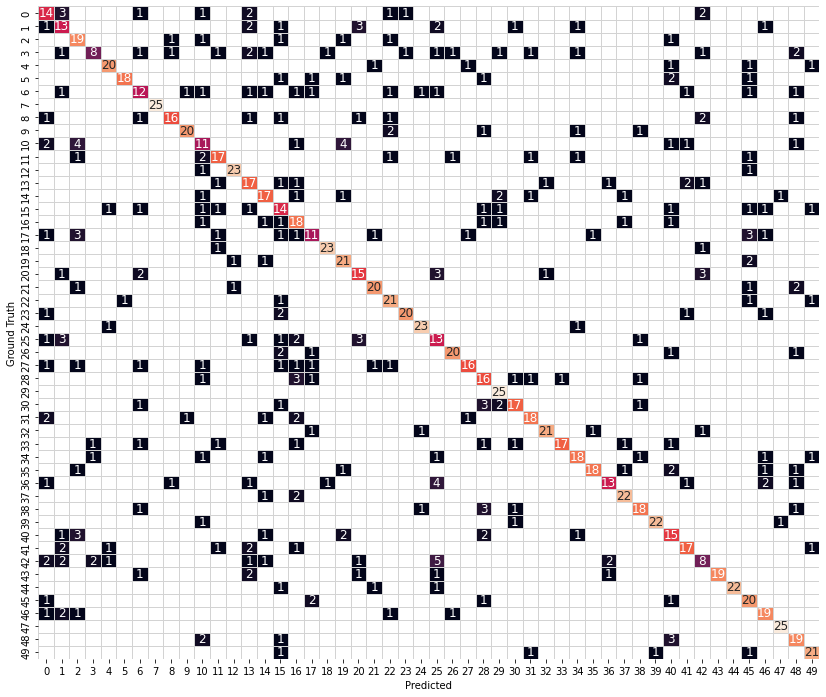

In [6]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)